**Castillo Reynoso Ivan Alexis**

**Robledo Ibarra Emiliano**

**Rodríguez Martínes Fanny Arlin**

**Rubio Juárez Elizabeth**

# Predicción de actividades humanas por medio de un acelerómetro

Los acelerómetros son instrumentos que miden el cambio en la velocidad de un objeto a lo largo del tiempo (unidad SI: m.s-2). La aceleración es directamente proporcional a la fuerza que actúa sobre el objeto para moverlo.

Se puede utilizar una medida de la aceleración del cuerpo o de sus segmentos para inferir una actividad física a lo largo del tiempo. Además, es posible derivar las dimensiones de la actividad, como la duración y la frecuencia.

Para este proyecto se utilizó la base de datos proveniente de [WISDM](https://www.cis.fordham.edu/wisdm/dataset.php). Los datos se recopilaron a partir de la aplicación Actitracker con propositos de investigación. 

Los datos se encuentran en un archivo csv y cuenta con 563 muestras, las cuales se clasifican en 6 grupos: Walking, Jogging, Stairs, Sitting, Standing y LyingDown. Los datos se recabaron cada 50 ms (20 Hz) para distintos usuarios y cada dato se ve como

<center>

| [user] | [activity] | [timestamp]   | [x-acceleration] | [y-accel]  | [z-accel]   |
|--------|------------|---------------|------------------|------------|-------------|
| 1679   | Walking    | 1370520469556 | 0.2941316        | -0.6356053 | -0.22693644 |

</center>

En total se tienen 2,980,765 renglones con los datos a utilizar donde se tiene la distribución de clases siguiente:

<center>

| Clase      | Cantidad  | Porcentaje |
|------------|-----------|------------|
| Walking    | 1,255,923 | 42.1%      |
| Sitting    | 663,706   | 22.3%      |
| Jogging    | 438,871   | 14.7%      |
| Standing   | 288,873   | 9.7%       |
| Lying Down | 275,967   | 9.3%       |
| Stairs     | 57,425    | 1.9%       |

</center>



In [ ]:
#Importamos algunas librerias para visualizar los datos
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
import datetime
!rm -rf ./logs/

Primero se importan los datos desde drive con el siguiente comando

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Datos = pd.read_csv('/content/drive/MyDrive/Proyecto_IA/WISDM_at_v2.0_raw.txt', #Se coloca la ruta
            names=['user','activity','timestamp','x-accel','y-accel','z-accel']).dropna() #Se genera una tabla con los datos 
Datos

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


user activity      timestamp   x-accel    y-accel       z-accel
0        1679  Walking  1370520469556  0.294132  -0.635605  -0.22693644;
1        1679  Walking  1370520469606 -0.499688  -0.604451  -0.22602014;
2        1679  Walking  1370520469656 -2.178345   0.713491   0.37201694;
3        1679  Walking  1370520469706 -2.797763   1.354899  -0.27763826;
4        1679  Walking  1370520469756 -2.167961  -1.327716   -0.5549711;
...       ...      ...            ...       ...        ...           ...
3005406   657  Walking  1316116428262  2.559677  -6.112090    3.1362782;
3005407   657  Walking  1316116428312  6.161787  -4.962480     9.152567;
3005408   657  Walking  1316116428367  1.295107 -11.975098    10.953622;
3005409   657  Walking  1316116428412  7.464677 -16.650175     5.588778;
3005410   657  Walking  1316116428462  2.368076  -3.736230  -0.23590942;

[2980765 rows x 6 columns]

In [ ]:
Datos = pd.read_csv('WISDM_at_v2.0_raw.txt', #Se coloca la ruta
            names=['user','activity','timestamp','x-accel','y-accel','z-accel']).dropna() #Se genera una tabla con los datos 
Datos

user activity      timestamp   x-accel    y-accel       z-accel
0        1679  Walking  1370520469556  0.294132  -0.635605  -0.22693644;
1        1679  Walking  1370520469606 -0.499688  -0.604451  -0.22602014;
2        1679  Walking  1370520469656 -2.178345   0.713491   0.37201694;
3        1679  Walking  1370520469706 -2.797763   1.354899  -0.27763826;
4        1679  Walking  1370520469756 -2.167961  -1.327716   -0.5549711;
...       ...      ...            ...       ...        ...           ...
3005406   657  Walking  1316116428262  2.559677  -6.112090    3.1362782;
3005407   657  Walking  1316116428312  6.161787  -4.962480     9.152567;
3005408   657  Walking  1316116428367  1.295107 -11.975098    10.953622;
3005409   657  Walking  1316116428412  7.464677 -16.650175     5.588778;
3005410   657  Walking  1316116428462  2.368076  -3.736230  -0.23590942;

[2980765 rows x 6 columns]

Podemos obtener características básicas

In [ ]:
Datos.describe()

user       x-accel       y-accel
count  2.980765e+06  2.980765e+06  2.980765e+06
mean   1.025269e+03  4.844853e+10 -1.373680e+05
std    4.901956e+02  8.364586e+13  2.371697e+08
min    1.940000e+02 -4.628739e+01 -4.094710e+11
25%    6.340000e+02 -2.230362e+00 -2.700000e-01
50%    7.050000e+02 -2.130529e-03  1.650000e+00
75%    1.603000e+03  2.508824e+00  8.850000e+00
max    1.802000e+03  1.444137e+17  8.013994e+01

Y notamos que los valores máximos para el eje x es enorme, ello implica que es imperativo filtrar los datos. Para limpiarlos y filtrar primero reemplazamos las cadenas innecesarias y cambiamos el tipo de dato que se le asigna

In [ ]:
Datos['z-accel'] = Datos['z-accel'].str.replace(';', '').astype(float)
Datos = Datos[Datos['timestamp'] != 0]
Datos = Datos[abs(Datos['x-accel']) <= 90] #El valor de la aceleración en cada coordenada debe ser menor o igual a 90
Datos = Datos[abs(Datos['y-accel']) <= 90]
Datos = Datos[abs(Datos['z-accel']) <= 90]
Datos = Datos.sort_values(by = ['user', 'timestamp'], ignore_index=True)

Datos

user  activity      timestamp   x-accel    y-accel   z-accel
0         194  Standing  1370367549273 -0.382459  10.473502 -1.676937
1         194  Standing  1370367549324 -0.382459  10.473502 -1.725970
2         194  Standing  1370367549374 -0.382459  10.473502 -1.765197
3         194  Standing  1370367549479 -0.382459  10.473502 -1.804424
4         194  Standing  1370367549529 -0.382459  10.522535 -1.804424
...       ...       ...            ...       ...        ...       ...
2980757  1802   Sitting  1379388132044  5.144053   3.618575 -7.868837
2980758  1802   Sitting  1379388132094  5.136119   3.581752 -7.784562
2980759  1802   Sitting  1379388132144  5.121300   3.572172 -7.801477
2980760  1802   Sitting  1379388132194  5.134473   3.569477 -7.728728
2980761  1802   Sitting  1379388132244  5.293592   3.773503 -7.810159

[2980762 rows x 6 columns]

Una vez "limpiada" podemos visualizar las muestras

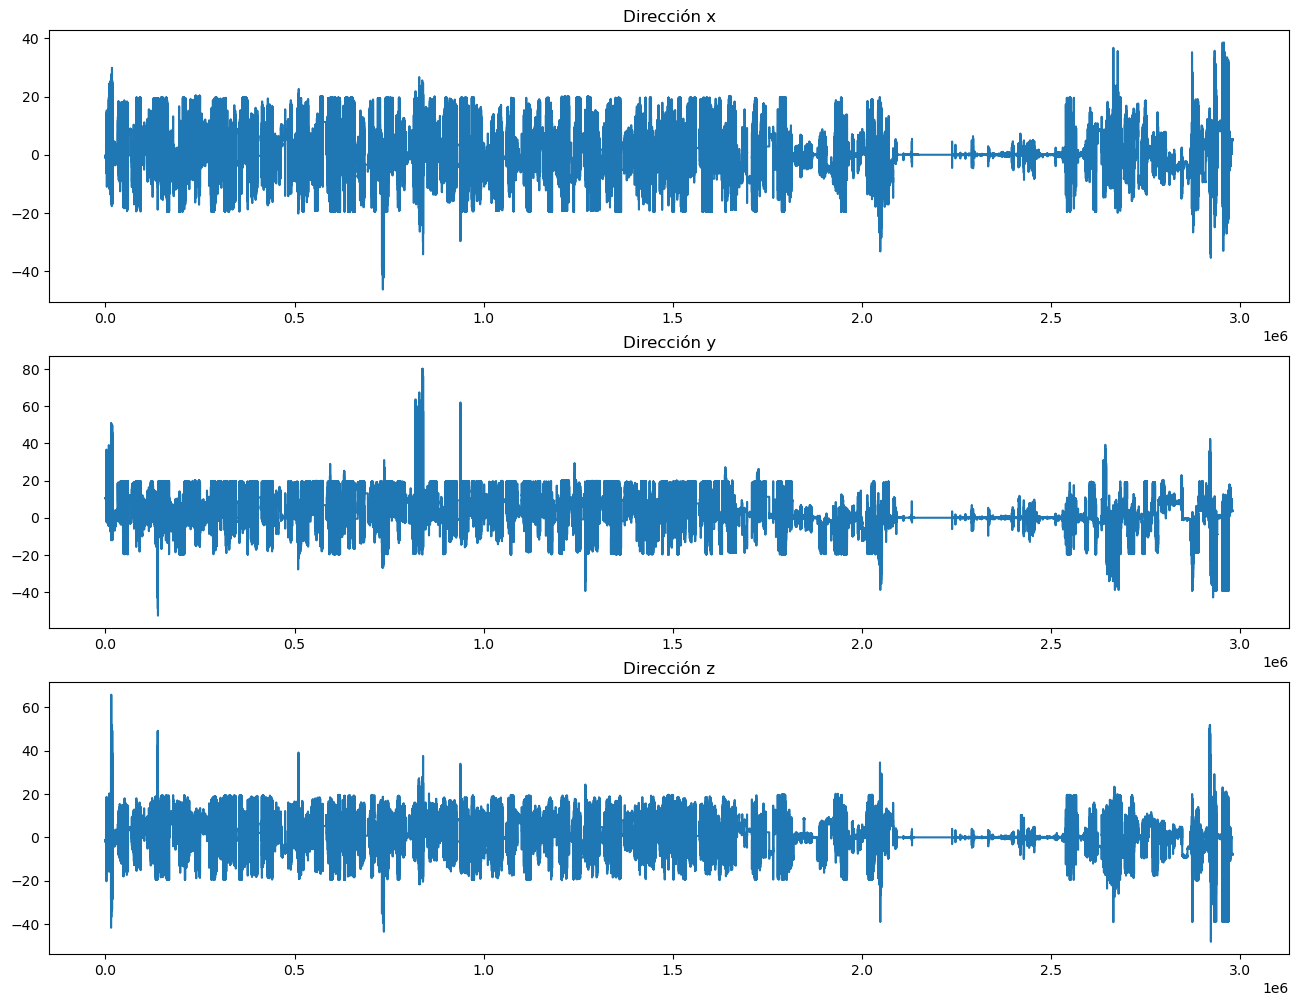

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3) #Esto para cada dirección de la aceleración 
fig.set_figheight(12)
fig.set_figwidth(16)
ax1.plot(Datos['x-accel'])
ax2.plot(Datos['y-accel'])
ax3.plot(Datos['z-accel'])
ax1.set_title('Dirección x')
ax2.set_title('Dirección y')
ax3.set_title('Dirección z')
fig.show()

Y, en una gráfica de barras puede apreciarse el tamaño de cada conjunto

In [ ]:
Cuenta = Datos.groupby(by=["activity"]).size().reset_index(name="counts")
px.bar(data_frame=Cuenta,x="activity",y="counts",color="activity")

Y por usuario también podemos ver las actividades realizadas

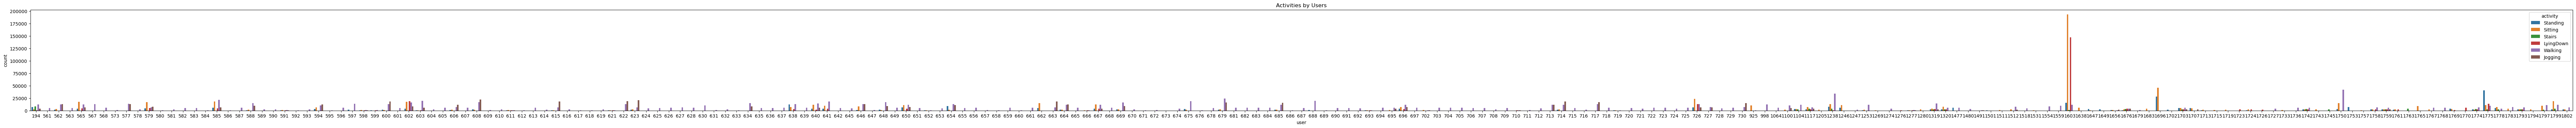

In [ ]:
plt.figure(figsize = (100, 4))
sn.countplot(x = 'user', hue = 'activity', data = Datos)
plt.title('Activities by Users')
plt.show()

Junto con el número de usuarios que se tienen

In [ ]:
Datos['user'].unique()
print('Tenemos', len(Datos['user'].unique()), 'usuarios en total')

Tenemos 225 usuarios en total


## Visualizando los datos

Ahora veamos un ejemplo de cómo se ven los registros de los usuarios. En particular elegimos uno que realizó las seis actividades y, a partir de ello realizaremos algunas observaciones

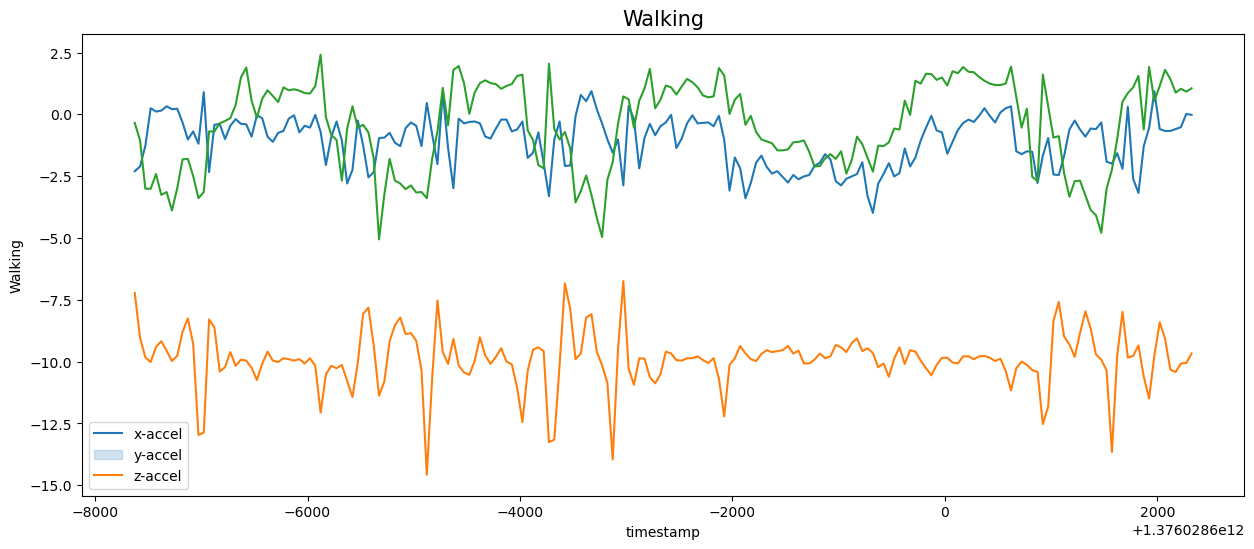

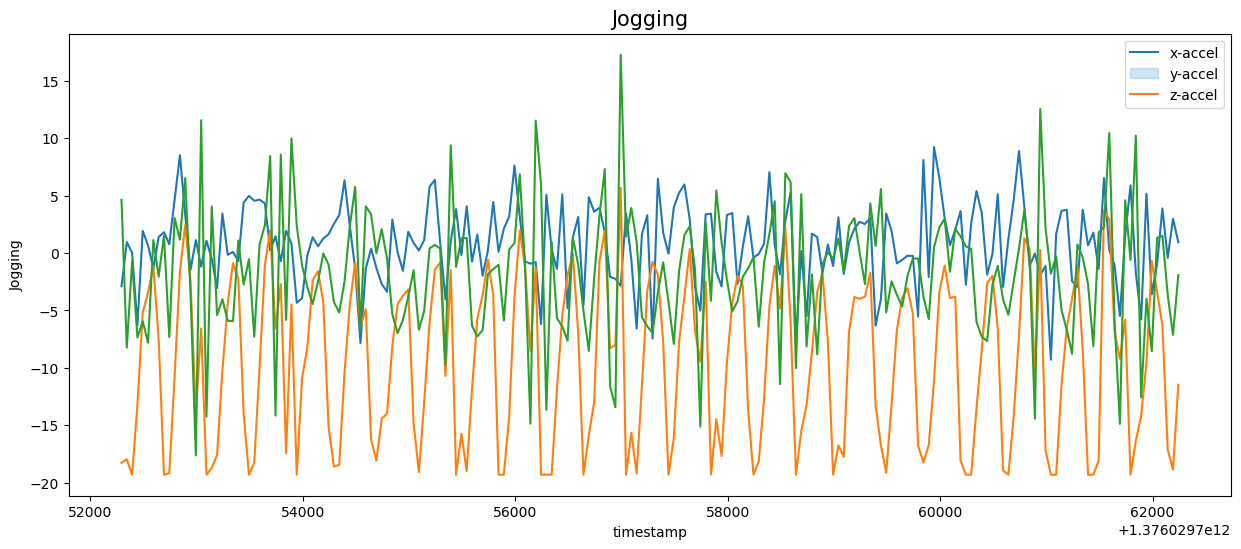

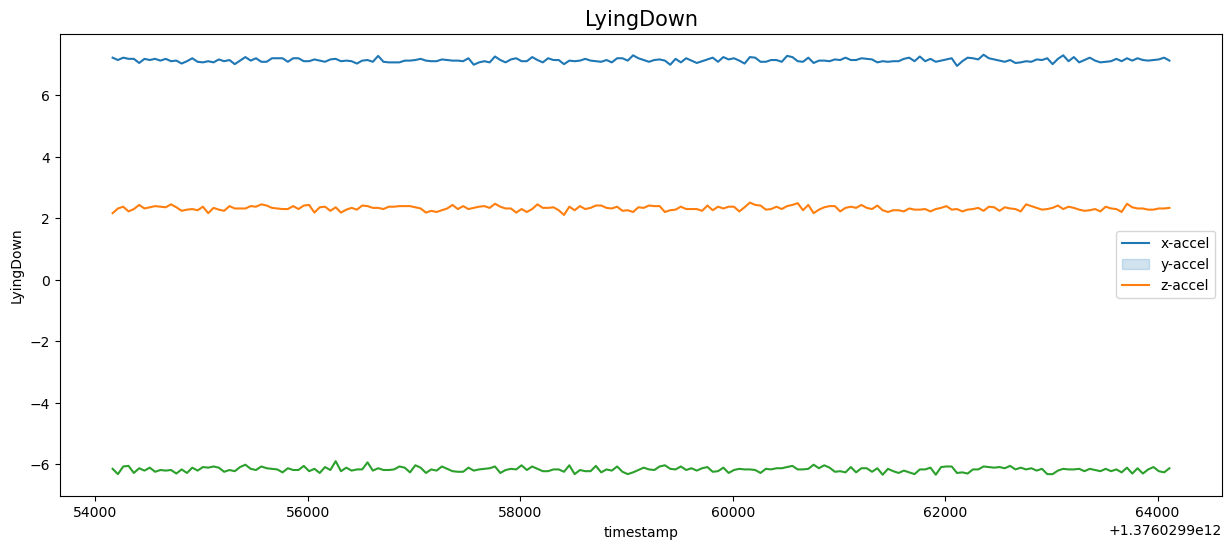

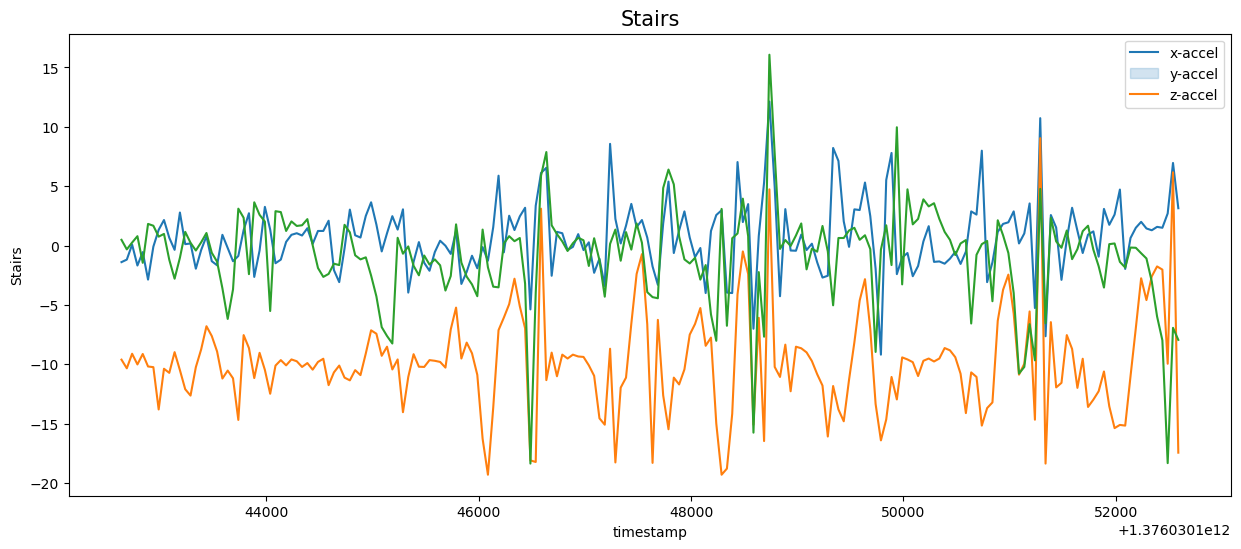

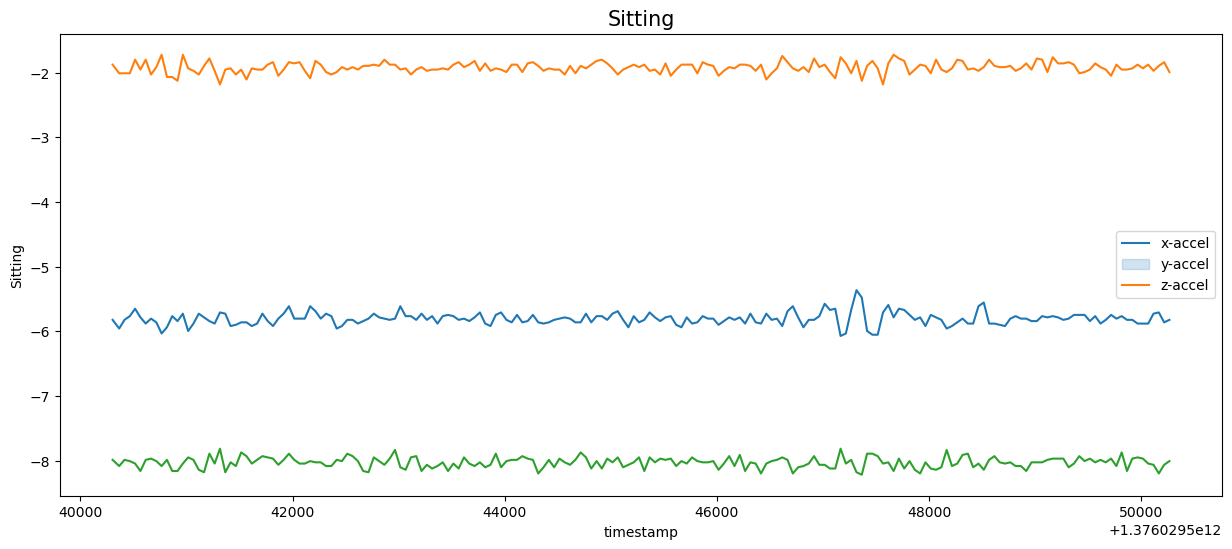

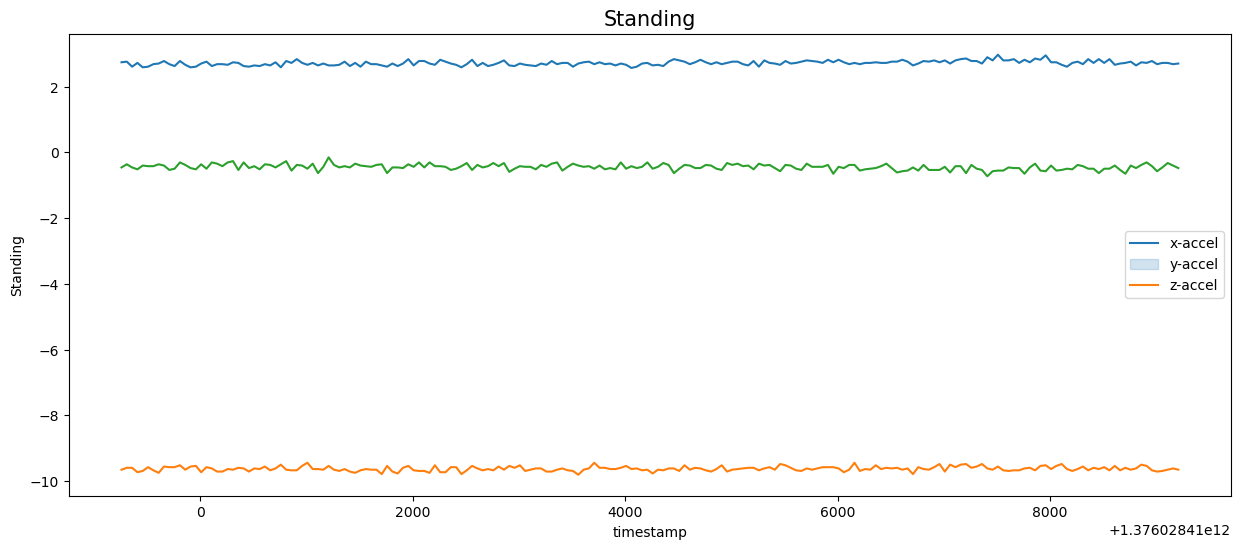

In [ ]:
for i in ['Walking', 'Jogging', 'LyingDown', 'Stairs', 'Sitting', 'Standing']:
  data_1759 = Datos[(Datos['user'] == 1759) & (Datos['activity'] == i)][400:600]
  plt.figure(figsize = (15, 6))
  sn.lineplot(y = 'x-accel', x = 'timestamp', data = data_1759)
  sn.lineplot(y = 'y-accel', x = 'timestamp', data = data_1759)
  sn.lineplot(y = 'z-accel', x = 'timestamp', data = data_1759)
  plt.legend(['x-accel', 'y-accel', 'z-accel'])
  plt.ylabel(i)
  plt.title(i, fontsize = 15)
  plt.show()

Se observan algunos aspectos a considerar:

1.   Para una actividad dada, la señal recabada se ubica centrada en un valor fijo (en la mayoría de los datos).
2.   Las señales son periódicas o conservan una forma similar a lo largo del tiempo.
3.   En general, las señales tienen duración variable y su duración depende del tiempo que la persona realizó la actividad.

Lo anterior presenta un reto: **sólo se cuentan con un número dado de muestras cuya duración es distinta**. Nuestro primer problema a resolver es definir la forma en la cual se representará la información.



# Preprocesamiento de datos

Primero debemos decidir cómo separar la información. Elegiremos un método común en el procesamiento de señales: *windowing*. Este método se utiliza para seleccionar sólo un rango del conjunto de la señal.

Se puede utilizar una duración de ventana arbitraria y, en este caso, nos quedaremos en una duración de 5 segundos. Además de dicho método, utilizaremos una técnica en la cual se considera información de la muestras cercanas, es decir, una superposición. Dicha ventana permitirá a la red alimentarse con datos que se relacionen entre sí. Esto se hace con el fin de evitar la pérdida de información una vez se segmentan los datos.

In [ ]:
# Agrupamos los datos por actividad
Datos_por_usuario = Datos.groupby(['user','activity'])

# Generamos listas donde se ubicarán
todos_x = []
todos_y = []
Junto = []

# Definimos el tamaño de la ventana y la superposición
ventana = 100
superposicion = 50

# Iteramos para conocer la actividad, la duración de esta
# y el usuario
for series in Datos_por_usuario:
  actividad = series[1].iloc[0]['activity']
  longitud  = len(series[1])
  datos = (series[1][['x-accel', 'y-accel', 'z-accel']])

  # Tomamos los datos y generamos las listas cortando cada ventana/superposición
  for i in range(0, longitud-ventana, superposicion):
    todos_x.append( datos.iloc[ i:i+ventana].to_numpy() )
    todos_y.append( actividad )
    Junto.append( [datos.iloc[ i:i+ventana].to_numpy(), actividad] )

# Verificamos que la longitud de datos es correcta
if len( todos_x ) == len( todos_y ):
  print('Tenemos',len(todos_x), 'datos a utilizar.' )

Tenemos 58833 datos a utilizar.


Observamos que en total pudimos extraer 58,833 datos del archivo. Y visualizamos la proporción de los mismos.

In [ ]:
# Para ver cuántos datos tenemos veamos las actividades y el total de cada una
x = []
y = []

# Iteramos sobre actividades y sumamos para hallar el total
activities = [ i for i in set(todos_y) ]
for i in activities:
  x.append(i)
  y.append(len( [ m for m in todos_y if m == i ] ))

# Graficamos
px.bar(x=x,y=y)

Se observa una clara disparidad en el número de muestras con las cuales se cuenta, es por ello que buscaremos crear más datos a partir de los ya existentes. Lo realizaremos agregando un poco de ruido a las mediciones ya existentes.

In [ ]:
print("Cantidad más grande:", max(y))


Cantidad más grande: 24813


In [ ]:
# Veamos la diferencia en cada conjunto respecto al máximo de actividades
L = max(y) - np.array(y)
print(L)

[11695 19367     0 23701 16120 19162]


In [ ]:
# Para compensar la diferencia de información, vamos a tomar la lista L
# e iterar sobre ella para generar el número de muestras adecuado

for i in range(len(y)):
  # Generamos la lista con los datos según la actividad
  _ = [ x[0] for x in Junto if x[1] == activities[i] ]
  # Elegimos las muestras que nos faltan, al azar
  N = np.random.choice( len(x[i]),size=L[i])
  # A cada muestra le añadimos ruido
  # le sumamos una distribución normal con sigma = 0.25
  for n in N:
    z = np.zeros(_[0].shape)
    z[:,0] = np.random.normal( 0, 0.25, size=z[:,0].shape)
    z[:,1] = np.random.normal( 0, 0.25, size=z[:,1].shape)
    z[:,2] = np.random.normal( 0, 0.25, size=z[:,2].shape)
    todos_x.append( _[n] + z )
    todos_y.append( activities[i] )

len(todos_x) == len(todos_y)

True

Y ya ahora todos los conjuntos tienen la misma cantidad de datos.

In [ ]:
# Graficamos los nuevos datos
x = []
y = []
activities = [ i for i in set(todos_y) ]
for i in activities:
  x.append(i)
  y.append(len( [ m for m in todos_y if m == i ] ))

px.bar(x=x,y=y)

# Procesando datos

Ya tenemos la misma cantidad de datos en cada conjunto, ahora falta dividirlos en los conjuntos para la red.


In [ ]:
# Creamos un diccionario para las actividades
Dicc = {'Walking':0, 
        'Jogging':1, 
        'LyingDown':2,
        'Stairs':3,
        'Sitting':4,
        'Standing':5 }

y_todos = [Dicc[i] for i in todos_y]

print(todos_y[10:50])
print(y_todos[10:50])

['Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging', 'Jogging']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
# Usamos la función to_categorical para traducir las actividades a one hot encoding
todos_y = tf.keras.utils.to_categorical(y_todos, num_classes=6, dtype="int")
print(todos_y)
print(todos_y.shape)

2022-12-14 00:34:53.422752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 00:34:53.695769: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-14 00:34:54.474588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/TeraChem/lib:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:/usr/local/TeraChem/lib:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2022-12-14 00:34:54.474701: W tensorflow/stream_executor/platform

[[0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 ...
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]]
(148878, 6)


Luego los reacomodamos

In [ ]:
import random

# Reorganizamos las muestras
Junto = list(zip(todos_x, todos_y))
random.shuffle(Junto)
todos_x, todos_y = zip(*Junto)
todos_x, todos_y = list(todos_x), list(todos_y)

Y ahora dividimos en un conjunto de entrenamiento y otro de prueba: usaremos 90% entrenamiento y 10% prueba.

In [ ]:
# Decidimos el porcentaje de entrenamiento
# y dividimos según este
t_r = 0.9
train_x = todos_x[:int(t_r*len(todos_x))]
train_y = todos_y[:int(t_r*len(todos_y))]

test_x = todos_x[int(t_r*len(todos_x)):]
test_y = todos_y[int(t_r*len(todos_y)):]

# Imprimimos las muestras que tenemos
print('Entrenamiento',len(train_x))
print('Prueba:',len(test_x))
print('Total:',len(todos_x))

Entrenamiento 133990
Prueba: 14888
Total: 148878


Para la red, lo que haremos será alimentarla con los registros individuales pero compactados en un único vector. Para ello mostremos uno de los datos que tomará la red

In [ ]:
# Y podemos ver que cada muestra es un arreglo de (100,3)
i = 20
prueba = test_x[i]
print(prueba)

print(prueba.shape)

[[ 9.89570657  0.90685612  0.96103562]
 [ 9.90674559  0.81968696  1.31243696]
 [10.24213536  0.73812794  1.15010995]
 [ 9.93465016  0.54800597  1.28266248]
 [10.09035711  0.39921865  1.02790394]
 [10.01666307  0.83910062  1.44533526]
 [10.07898145  0.49442318  1.57724348]
 [10.23496531  0.74877248  1.59363236]
 [ 9.91887549  0.6404771   1.21091754]
 [10.42265145  0.95205694  1.24468146]
 [ 9.9511333   0.69656265  1.6934929 ]
 [10.50097445  1.1219829   1.0537252 ]
 [ 9.88614943  0.75178838  1.54515727]
 [10.15266679  0.84458697  2.04410876]
 [ 9.58558798  0.62197365  0.75863712]
 [10.22443592  0.33338754  1.17990349]
 [ 9.73899648  0.78745265  1.37520765]
 [10.47510125  0.42928451  1.19144003]
 [10.13334273  0.90540372  1.35235725]
 [ 9.92729171  0.66404016  1.32680453]
 [10.04339992  0.68915524  0.84066106]
 [ 9.7887573   1.11162888  1.54951547]
 [10.40502915  0.69811845  0.98110898]
 [10.19894592  0.74459664  1.15237856]
 [10.04590439  0.81151985  1.21458699]
 [10.59500665  0.76981362

Notamos, es un arreglo de tamaño (100, 3), entonces lo que haremos será reorganizarlos en un vector de longitud 300.

In [ ]:
# Los aplanamos
prueba1D = prueba.reshape(300)
prueba1D.shape

(300,)

Ahora pongámoslo en un arreglo

In [ ]:
# Y lo hacemos para cada dato
train_x = np.array( [ x.reshape(300) for x in train_x ] )
test_x = np.array( [ x.reshape(300) for x in test_x ] )

In [ ]:
# Lo volvemos arreglo
train_y = np.array( train_y )
test_y = np.array( test_y )

In [ ]:
# Y obten
print('Tipo de dato de train_x:', type(train_x))
print('Tipo de dato de test_x:', type(test_x))

print('Forma de train_x:', train_x.shape)
print('Forma de test_x:', test_x.shape)

print('Tipo de dato de train_y:', type(train_y))
print('Tipo de dato de test_y:', type(test_y))

print('Forma de train_y:', train_y.shape)
print('Forma de test_y:', test_y.shape)

Tipo de dato de train_x: <class 'numpy.ndarray'>
Tipo de dato de test_x: <class 'numpy.ndarray'>
Forma de train_x: (133990, 300)
Forma de test_x: (14888, 300)
Tipo de dato de train_y: <class 'numpy.ndarray'>
Tipo de dato de test_y: <class 'numpy.ndarray'>
Forma de train_y: (133990, 6)
Forma de test_y: (14888, 6)


# Creando el modelo

Ya tenemos todo listo, sólo falta crear el modelo y alimentarlo con los datos

In [ ]:
# Importamos todas las paqueterías necesarias

from keras.models import Sequential
from keras.layers import Input, Dense, Flatten
from keras.layers import Dropout, Activation
from keras.layers import Convolution1D, MaxPooling1D, AveragePooling1D
from keras.layers import ZeroPadding1D, BatchNormalization
from keras.optimizers import SGD
from keras.models import Model
from keras.utils import plot_model
from keras.utils import to_categorical
from keras import initializers
from keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Conv1D

import keras

In [ ]:
train_x=np.reshape(train_x,(133990, 300,1))
test_x=np.reshape(test_x,(14888, 300,1))

In [ ]:
def architecture(batch_normalization, dropout, input_shape, activation, num_classes):

    model = Sequential()
    
    model.add(Convolution1D(18, 12, strides = 3, padding ='same', input_shape=(300,1))) #convolution layer
    if batch_normalization: 
        model.add(BatchNormalization())
    model.add(Activation(activation)) #activation
    if dropout: 
        model.add(Dropout(0.3))
    model.add(AveragePooling1D(pool_size=2, strides=2)) #pooling layer
    
    model.add(Convolution1D(12, 10, strides = 3, padding ='same'))
    if batch_normalization: 
        model.add(BatchNormalization())
    model.add(Activation(activation))
  
    model.add(Convolution1D(15, 18, strides = 2, padding ='same'))
    if batch_normalization: 
        model.add(BatchNormalization())
    model.add(Activation(activation))
    if dropout: 
        model.add(Dropout(0.3))
    model.add(AveragePooling1D(pool_size=3, strides=1))
    
    model.add(Flatten())
    
    model.add(Dense(35))
    if batch_normalization: 
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    if dropout: 
        model.add(Dropout(0.3))
        
    model.add(Dense(15))
    if batch_normalization: 
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    if dropout:     
        model.add(Dropout(0.3))
        
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model

In [ ]:
# Llamemos a la función 
learning_rate=0.01
input_shape = (300,1)
activation ='sigmoid'
num_classes = 6
dropout = True
batch_normalization = True
#dropout, input_shape, activation, num_classes

WISDM_model = architecture(batch_normalization,dropout, input_shape, activation, num_classes)

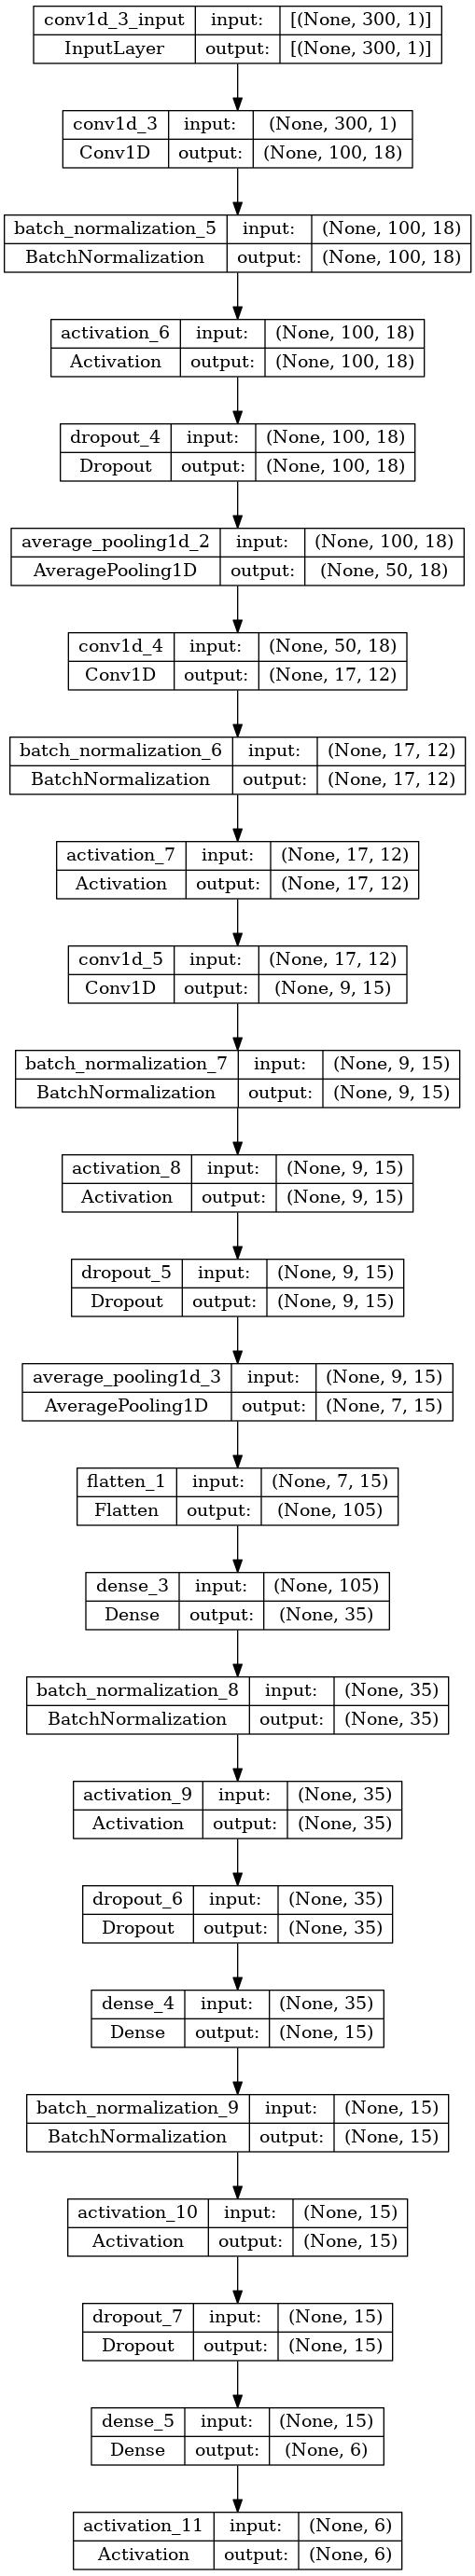

In [ ]:
plot_model(WISDM_model, to_file='mnist_model.png', show_shapes=True, rankdir='TB', show_layer_names=True)

In [ ]:
# Veamos los parámetros del modelo 
WISDM_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 100, 18)           234       
                                                                 
 batch_normalization_5 (Batc  (None, 100, 18)          72        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 100, 18)           0         
                                                                 
 dropout_4 (Dropout)         (None, 100, 18)           0         
                                                                 
 average_pooling1d_2 (Averag  (None, 50, 18)           0         
 ePooling1D)                                                     
                                                                 
 conv1d_4 (Conv1D)           (None, 17, 12)           

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
loss_function = 'categorical_crossentropy'
metric_function = 'accuracy'

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard


!mkdir logs
#!mkdir logs/WISDM

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
mkdir: cannot create directory ‘logs’: File exists


In [ ]:
# 
WISDM_model.compile(optimizer = optimizer, loss = loss_function, metrics = [metric_function])

In [ ]:
import time

os.environ["CUDA_VISIBLE_DEVICES"]="0"
validation_portion = 0.07
batch_size = 200
epochs = 150
start_time = time.time()

tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=1)

history_model = WISDM_model.fit(train_x, train_y, 
                          batch_size=batch_size, 
                          epochs=epochs,
                          validation_split = validation_portion,
                          shuffle=True,
                          callbacks=[tensorboard_callback])

end_time = time.time()
print("Time for training: {:10.4f}s".format(end_time - start_time))

Epoch 1/150
624/624 [==============================] - 10s 13ms/step - loss: 1.6145 - accuracy: 0.3379 - val_loss: 1.2483 - val_accuracy: 0.5632
Epoch 2/150
624/624 [==============================] - 7s 11ms/step - loss: 1.3692 - accuracy: 0.4483 - val_loss: 1.1198 - val_accuracy: 0.5617
Epoch 3/150
624/624 [==============================] - 7s 12ms/step - loss: 1.2731 - accuracy: 0.4939 - val_loss: 1.0445 - val_accuracy: 0.5658
Epoch 4/150
624/624 [==============================] - 8s 12ms/step - loss: 1.2010 - accuracy: 0.5309 - val_loss: 0.9578 - val_accuracy: 0.6547
Epoch 5/150
624/624 [==============================] - 8s 12ms/step - loss: 1.1465 - accuracy: 0.5595 - val_loss: 0.8951 - val_accuracy: 0.6886
Epoch 6/150
624/624 [==============================] - 8s 13ms/step - loss: 1.0991 - accuracy: 0.5832 - val_loss: 0.8534 - val_accuracy: 0.6939
Epoch 7/150
624/624 [==============================] - 8s 13ms/step - loss: 1.0627 - accuracy: 0.5993 - val_loss: 0.8175 - val_accuracy

In [ ]:
# Guardar el modelo
WISDM_model.save('WISDM_model.h5')

# Para cargar el modelo con 
# loss:     0.3359 - accuracy:     0.8908 
# val_loss: 0.2584 - val_accuracy: 0.9145
#WISDM = tf.keras.models.load_model('/content/drive/MyDrive/Proyecto_IA/WISDM_model.h5')

In [ ]:
loss = history_model.history['loss'][-1]
val_loss = history_model.history['val_loss'][-1]
acc = history_model.history['accuracy'][-1]
val_acc = history_model.history['val_accuracy'][-1]

title_acc = str(activation) + ', Adam, lr=' + str(learning_rate) + '\n' + 'acc_train: ' + \
        str(np.round(acc, 4)) + ', acc_val: ' + str(np.round(val_acc, 4))\
        + '\n' + 'BatchNorm=' + str(batch_normalization)\
        + '\n' + 'Dropout=' + str(dropout)


title_loss = str(activation) + ', Adam, lr=' + str(learning_rate) + '\n' +'loss_train: ' + \
        str(np.round(loss, 4)) + ', loss_val: ' + str(np.round(val_loss, 4))\
        + '\n' + 'BatchNorm=' + str(batch_normalization)\
        + '\n' + 'Dropout=' + str(dropout)

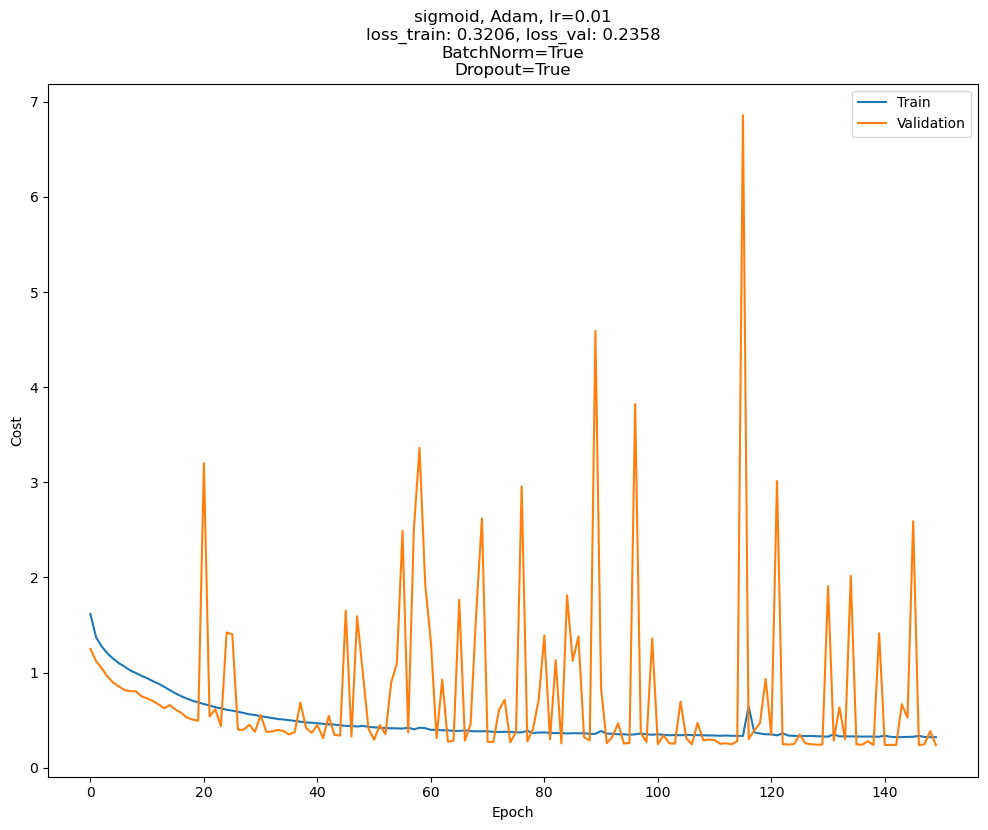

In [ ]:
plt.figure(figsize=(12,9))

plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title(title_loss)
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right');

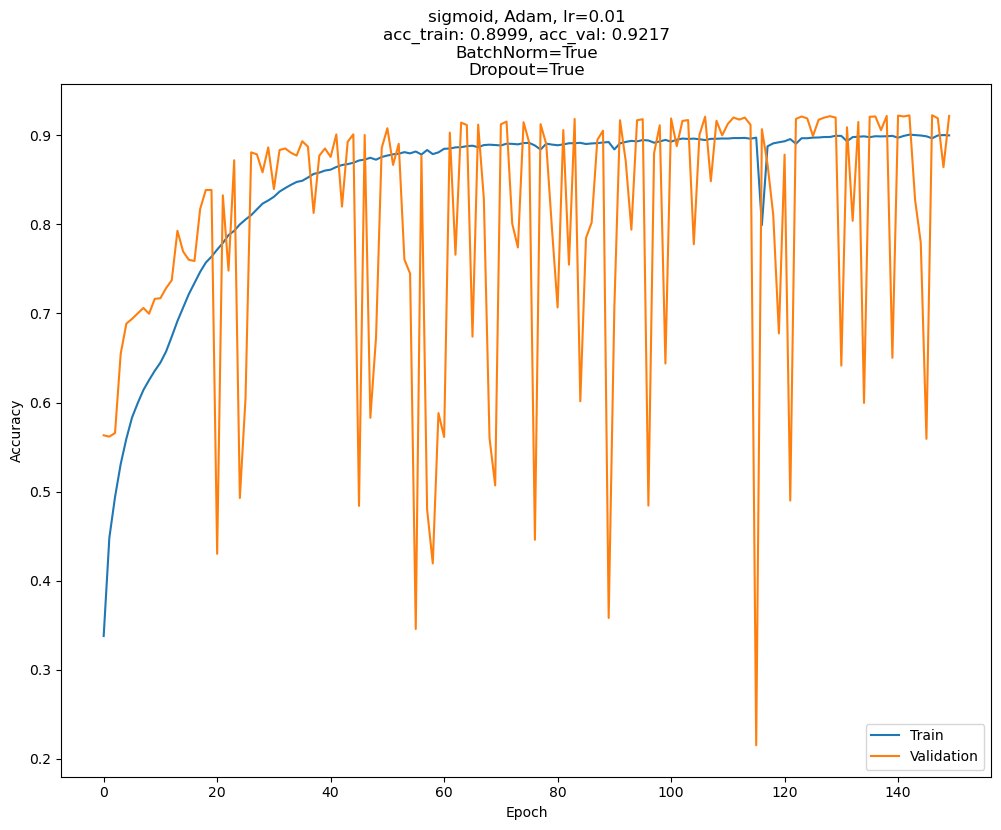

In [ ]:
plt.figure(figsize=(12,9))

plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title(title_acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right');

In [ ]:
scores = WISDM_model.evaluate(test_x, test_y)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

466/466 [==============================] - 2s 4ms/step - loss: 0.2410 - accuracy: 0.9187
Test loss: 0.2410394549369812
Test accuracy: 0.9187265038490295


In [ ]:
y_target=np.argmax(test_y, axis=1)
predictions = WISDM_model.predict(test_x)
y_pred = np.argmax(predictions, axis=1)

466/466 [==============================] - 2s 4ms/step


In [ ]:
Dicc = {'Walking':0, 
        'Jogging':1, 
        'LyingDown':2,
        'Stairs':3,
        'Sitting':4,
        'Standing':5 }


from sklearn.metrics import classification_report, confusion_matrix 
print('Confusion Matrix \n')
print(confusion_matrix(y_target, y_pred), '\n')
print('Classification Report \n ')
target_names = list(Dicc.keys())
print(classification_report(y_target, y_pred, target_names=target_names))

Confusion Matrix 

[[2272    6    0    0  147   41]
 [  41 2376    0    0   78   12]
 [   0    0 2012    0  504    0]
 [ 107    3    0 2338    4    1]
 [  28    1    8    0 2376   34]
 [  11    0    0    0  184 2304]] 

Classification Report 
 
              precision    recall  f1-score   support

     Walking       0.92      0.92      0.92      2466
     Jogging       1.00      0.95      0.97      2507
   LyingDown       1.00      0.80      0.89      2516
      Stairs       1.00      0.95      0.98      2453
     Sitting       0.72      0.97      0.83      2447
    Standing       0.96      0.92      0.94      2499

    accuracy                           0.92     14888
   macro avg       0.93      0.92      0.92     14888
weighted avg       0.93      0.92      0.92     14888



<AxesSubplot:>

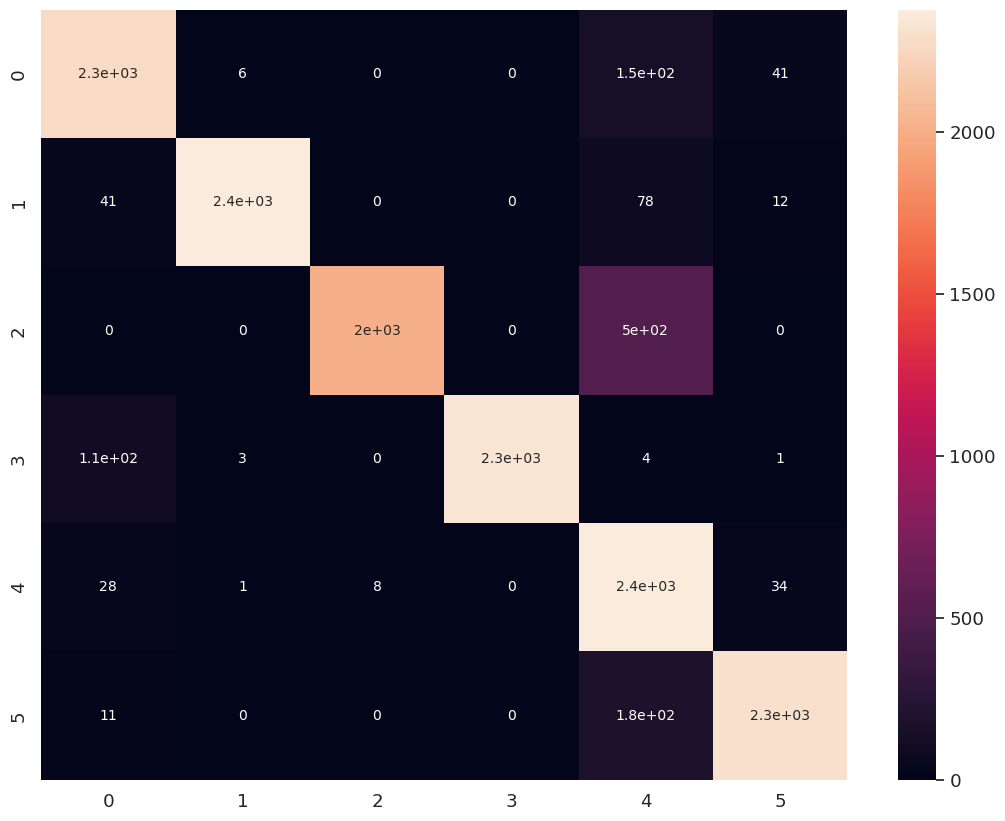

In [ ]:
plt.figure(figsize=(13,10))
snn_df_cm = pd.DataFrame(confusion_matrix(y_target, y_pred), range(6), range(6))  
#snn_df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred), range(7), range(7))  #para sparse
#plt.figure(figsize = (16,14))  
sn.set(font_scale=1.2) #for label size  
sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 10}) # font size  
#plt.savefig('matrix-impares.png'); 

In [ ]:
#Hagamos predicciones
predictions = WISDM_model.predict(test_x)

466/466 [==============================] - 2s 3ms/step


In [ ]:
sample = 777

# Predicting the digit associated to the sample 
# np.argmax returns the index of the maximum value

prediction = np.argmax(predictions[sample])

print('For the sample number', sample, 'the prediction is the activity:', prediction)

For the sample number 777 the prediction is the activity: 3


In [ ]:
print('For the sample number', sample, 'the associated activity is:', int(np.argmax(test_y[sample])))

For the sample number 777 the associated activity is: 3


# ¿Y si predecimos datos monitoreados?

La base de datos que se utilizó, cuenta con otro conjunto de datos. Estos datos resultan ser mediciones controladas por la misma empresa que adquirió los datos

In [4]:
#Monitoreados = pd.read_csv('/content/drive/MyDrive/Proyecto_IA/Monitoreados.txt',
#            names=['user','activity','timestamp','x-accel','y-accel','z-accel']).dropna()
import pandas as pd
Monitoreados = pd.read_csv('WISDM_ar_v1.1_raw.txt',
            names=['user','activity','timestamp','x-accel','y-accel','z-accel']).dropna()

Monitoreados['z-accel'] = Monitoreados['z-accel'].str.replace(';', '').astype(float)
Monitoreados = Monitoreados[Monitoreados['timestamp'] != 0]
#Monitoreados = Monitoreados[abs(Monitoreados['x-accel']) <= 90]
#Monitoreados = Monitoreados[abs(Monitoreados['y-accel']) <= 90]
#Monitoreados = Monitoreados[abs(Monitoreados['z-accel']) <= 90]
Monitoreados = Monitoreados.sort_values(by = ['user', 'timestamp'], ignore_index=True)

Monitoreados

user  activity       timestamp  x-accel  y-accel   z-accel
0           1   Walking   4991922345000     0.69    10.80 -2.030000
1           1   Walking   4991972333000     6.85     7.44 -0.500000
2           1   Walking   4992022351000     0.93     5.63 -0.500000
3           1   Walking   4992072339000    -2.11     5.01 -0.690000
4           1   Walking   4992122358000    -4.59     4.29 -1.950000
...       ...       ...             ...      ...      ...       ...
1085358    36  Standing  15049012250000    -0.91     9.43  2.533385
1085359    36  Standing  15049062268000    -1.18     9.51  2.492524
1085360    36  Standing  15049112287000    -1.50     9.53  2.533385
1085361    36  Standing  15049162275000    -2.07     8.77  2.179256
1085362    36  Standing  15049212262000    -2.14     9.89  3.255263

[1085363 rows x 6 columns]

In [5]:
Monitoreados.describe()

user     timestamp       x-accel       y-accel       z-accel
count  1.085363e+06  1.085363e+06  1.085363e+06  1.085363e+06  1.085363e+06
mean   1.883053e+01  3.380434e+13  6.707109e-01  7.341477e+00  4.159457e-01
std    1.023379e+01  4.960684e+13  6.889074e+00  6.739415e+00  4.781957e+00
min    1.000000e+00  7.345234e+10 -1.961000e+01 -1.961000e+01 -1.980000e+01
25%    1.000000e+01  2.076792e+12 -2.960000e+00  3.340000e+00 -2.260000e+00
50%    1.900000e+01  1.009662e+13  3.400000e-01  8.010000e+00 -4.000000e-02
75%    2.800000e+01  5.559398e+13  4.480000e+00  1.165000e+01  2.760000e+00
max    3.600000e+01  2.093974e+14  1.995000e+01  2.004000e+01  1.961000e+01

In [ ]:
Datos_por_usuario = Monitoreados.groupby(['user','activity'])

monit_x = []
monit_y = []
Junto = []

ventana = 100
superposicion = 50

for series in Datos_por_usuario:
  actividad = series[1].iloc[0]['activity']
  longitud  = len(series[1])
  datos = (series[1][['x-accel', 'y-accel', 'z-accel']])

  for i in range(0, longitud-ventana, superposicion):
    monit_x.append( datos.iloc[ i:i+ventana].to_numpy() )
    monit_y.append( actividad )
    Junto.append( [datos.iloc[ i:i+ventana].to_numpy(), actividad] )

if len( monit_x ) == len( monit_y ):
  print('Tenemos',len(monit_y), 'datos a utilizar.' )

Tenemos 21438 datos a utilizar.


In [ ]:
Dicc = {'Walking':0, 
        'Jogging':1, 
        'Upstairs':2,
        'Downstairs':3,
        'Sitting':4,
        'Standing':5 }

y_monit = [Dicc[i] for i in monit_y]

print(monit_y[10:15])
print(y_monit[10:15])

print('\n')

monit_y = tf.keras.utils.to_categorical(y_monit, num_classes=6, dtype="int")
print(monit_y)
print(monit_y.shape)


Junto = list(zip(monit_x, monit_y))
random.shuffle(Junto)
monit_x, monit_y = zip(*Junto)
monit_x, monit_y = list(monit_x), list(monit_y)

Test_x = np.array( [ x.reshape(300) for x in monit_x ] )
Test_y = np.array( monit_y )

Test_x=np.reshape(Test_x,(21438, 300,1))

['Downstairs', 'Downstairs', 'Downstairs', 'Downstairs', 'Downstairs']
[3, 3, 3, 3, 3]


[[0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 ...
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]
(21438, 6)


In [ ]:
print('Tipo de dato de Test_x:', type(Test_x))
print('Forma de Test_x:', Test_x.shape)

print('Tipo de dato de Test_y:', type(Test_y))
print('Forma de Test_y:', Test_y.shape)

Tipo de dato de Test_x: <class 'numpy.ndarray'>
Forma de Test_x: (21438, 300, 1)
Tipo de dato de Test_y: <class 'numpy.ndarray'>
Forma de Test_y: (21438, 6)


In [ ]:
scores = WISDM_model.evaluate(Test_x, Test_y)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

670/670 [==============================] - 3s 4ms/step - loss: 1.3788 - accuracy: 0.7785
Test loss: 1.3787829875946045
Test accuracy: 0.7785241007804871


In [ ]:
y_target=np.argmax(Test_y, axis=1)
predictions = WISDM_model.predict(Test_x)
y_pred = np.argmax(predictions, axis=1)

670/670 [==============================] - 3s 4ms/step


In [ ]:
Dicc = {'Walking':0, 
        'Jogging':1, 
        'Upstairs':2,
        'Downstairs':3,
        'Sitting':4,
        'Standing':5 }


from sklearn.metrics import classification_report, confusion_matrix 
print('Confusion Matrix \n')
print(confusion_matrix(y_target, y_pred), '\n')
print('Classification Report \n ')
target_names = list(Dicc.keys())
print(classification_report(y_target, y_pred, target_names=target_names))

Confusion Matrix 

[[8420    1    0    1    2    0]
 [ 132 6428    0    0    0    0]
 [2163  191    0   14    0   36]
 [1913   34    0    5    0    3]
 [   6    0   51    0 1058   47]
 [   2    0    1    0  151  779]] 

Classification Report 
 
              precision    recall  f1-score   support

     Walking       0.67      1.00      0.80      8424
     Jogging       0.97      0.98      0.97      6560
    Upstairs       0.00      0.00      0.00      2404
  Downstairs       0.25      0.00      0.01      1955
     Sitting       0.87      0.91      0.89      1162
    Standing       0.90      0.83      0.87       933

    accuracy                           0.78     21438
   macro avg       0.61      0.62      0.59     21438
weighted avg       0.67      0.78      0.70     21438



<AxesSubplot:>

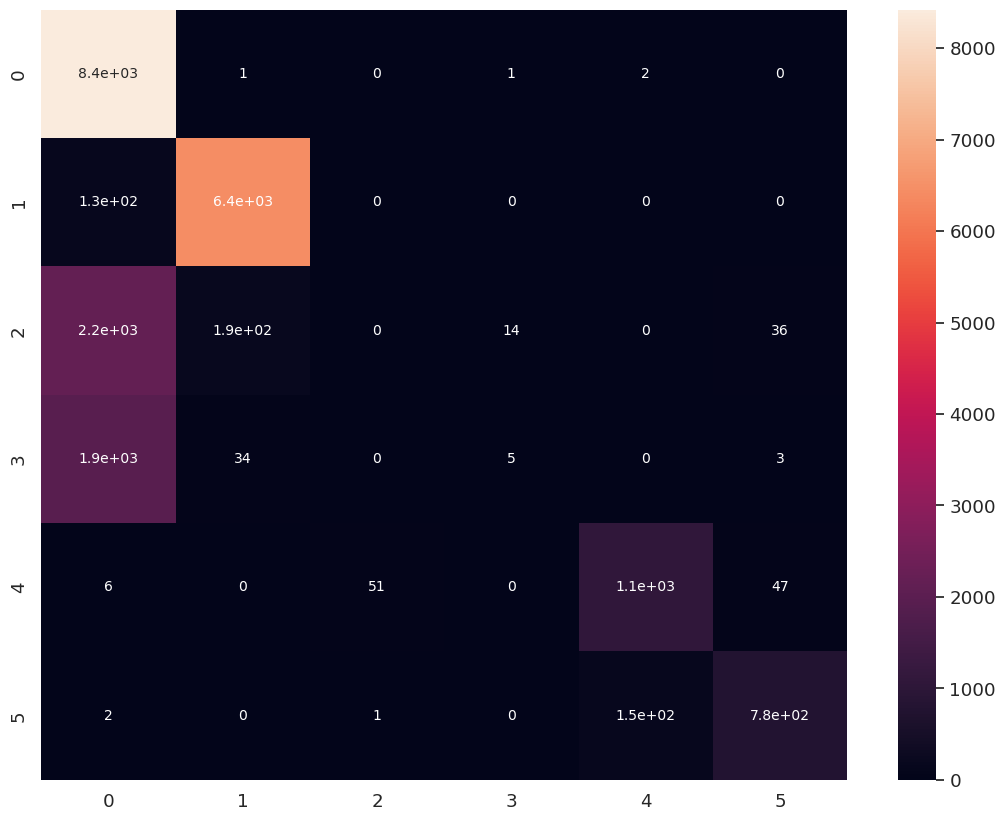

In [ ]:
plt.figure(figsize=(13,10))
snn_df_cm = pd.DataFrame(confusion_matrix(y_target, y_pred), range(6), range(6))  
#snn_df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred), range(7), range(7))  #para sparse
#plt.figure(figsize = (16,14))  
sn.set(font_scale=1.2) #for label size  
sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 10}) # font size  
#plt.savefig('matrix-impares.png'); 

Es notorio lo bien que predice caminar, trotar y sentarse. La razón por la que tiene un problema es debido a que recibe actividades distintas: al parecer es distinto subir o bajar escaleras además de que aquí no existe la actividad de estar acostado.

# Discusión

Se obtuvieron las "Confusion Matrix" para el conjunto de prueba y un conjunto distinto a la base de datos original. Se observa que para el conjunto de prueba se tienen predicciones con un accuracy superior al 90%, excepto para la actividad "Sitting", la cual tiene un accuracy del 73%. Se piensa que esto se debe a que esta actividad tiene comportamientos similares a las actividades "Standing" y "Lying Down". En la matriz se observa que los recuadros donde las predicciones de "Sitting" concuerdan con los valores de "Standing" y "Lying Down" están más iluminados, lo que implica que para "Sitting" las predicciones no son tan precisas. 

Posterimente, se trabajó con una base de datos distinta. Sin embargo, a diferencia de la otra base de datos, las actividades son: "Walking", "Jogging", "Upstairs", "Downstairs", "Sitting" y "Standing". En la "Confusion Matrix" para las predicciones de estos datos se observa que el accuracy es de 69% para "Walking" y de 91% para "Jogging". Continuando con las siguientes dos actividades, "Upstairs" y "Downstairs", se tienen accuracy de 0% y 22% respectivamente. Esto se debe a que el modelo se entrenó con diferentes actividades, y por lo tanto datos. Finalmente, para las últimas dos actividades, "Sitting" y "Standing",se tienen accuracy del 75% y 99% respectivamente. Es importante recalcar que en la "Confusion Matrix" los colores para las útlimas dos no son tan brillantes por la cantidad de datos que se tienen. Así mismo, el modelo está limitado por el parecido que tienen algunas actividades como  "Sitting" y "Standing", que en general presentan valores constantes, o "Walking" y "Stairs", que son actividades periódicas. Está puede ser la rázon por la cual el modelo se confunde.

En conclusión, se desarrolló un modelo con el propósito de predecir actividades humanas considerando sensores implementados en los Smartphones. Las actividades que dicho modelo puede predecir son "Walking", "Jogging", "LyingDown", "Stairs", "Sitting" y "Standing". Se realizaron pruebas para dos conjuntos: el primero provenia de la misma base de datos con la que se entrenó el modelo y el segundo correspondia a una base de datos distinta. Para el primer conjunto se obtuvieron acurracy superiores al 90% para la mayoría de las actividades, excepto por "Sitting" donde se obtuvo un accuracy del 73%. Mientras que para el segundo conjunto se obtuvieron acurracy del 69% para "Walking", 91% para "Jogging", 75% para "Sitting" y 99% para "Standing". Para este conjunto no se obtuvieron predicciones para "Lying Down" y "Stairs" ya que el conjunto de entrenamiento no contenia datos para estas actividades.



In [ ]:
%tensorboard --logdir logs